# Creating Customer Segments

In this project you, will analyze a dataset containing annual spending amounts for internal structure, to understand the variation in the different types of customers that a wholesale distributor interacts with.

Instructions:

- Run each code block below by pressing **Shift+Enter**, making sure to implement any steps marked with a TODO.
- Answer each question in the space provided by editing the blocks labeled "Answer:".
- When you are done, submit the completed notebook (.ipynb) with all code blocks executed, as well as a .pdf version (File > Download as).

In [1]:
# Import libraries: NumPy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tell iPython to include plots inline in the notebook
%matplotlib inline

# Read dataset
data = pd.read_csv("wholesale-customers.csv")
print "Dataset has {} rows, {} columns".format(*data.shape)
print data.head()  # print the first 5 rows

Dataset has 440 rows, 6 columns
   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0  12669  9656     7561     214              2674          1338
1   7057  9810     9568    1762              3293          1776
2   6353  8808     7684    2405              3516          7844
3  13265  1196     4221    6404               507          1788
4  22615  5410     7198    3915              1777          5185


## Feature Transformation

**1)** In this section you will be using PCA and ICA to start to understand the structure of the data. Before doing any computations, what do you think will show up in your computations? List one or two ideas for what might show up as the first PCA dimensions, or what type of vectors will show up as ICA dimensions.

Answer:
- Because PCA is based on the covariance matrix, maybe only one item will pop out such as Fresh. This has a standard deviation compared to other items so this will probably dominate the first component. 
- ICA will show independant vectors that explains the original signal. It's a little bit hard to guess at first what will come out.

### PCA

In [2]:
# TODO: Apply PCA with the same number of dimensions as variables in the dataset
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(data)

# Print the components and the amount of variance in the data contained in each dimension
print pd.DataFrame(
    pca.components_, 
    columns = ['PC{}'.format(i) for i in range(1,7)],
    index = ['Fresh', 'Milk', 'Grocery','Frozen', 'Detergents_Paper', 'Delicatessen']
    )
print pd.DataFrame(
    pca.explained_variance_ratio_.reshape((1,6)) , 
    columns = ['PC{}'.format(i) for i in range(1,7)],
    index = ['Variance']
    )
             

                       PC1       PC2       PC3       PC4       PC5       PC6
Fresh            -0.976537 -0.121184 -0.061540 -0.152365  0.007054 -0.068105
Milk             -0.110614  0.515802  0.764606 -0.018723  0.365351  0.057079
Grocery          -0.178557  0.509887 -0.275781  0.714200 -0.204410  0.283217
Frozen           -0.041876 -0.645640  0.375460  0.646292  0.149380 -0.020396
Detergents_Paper  0.015986  0.203236 -0.160292  0.220186  0.207930 -0.917077
Delicatessen     -0.015763  0.033492  0.410939 -0.013289 -0.871284 -0.265417
               PC1       PC2      PC3       PC4       PC5       PC6
Variance  0.459614  0.405172  0.07003  0.044023  0.015022  0.006138


## **2)** How quickly does the variance drop off by dimension? If you were to use PCA on this dataset, how many dimensions would you choose for your analysis? Why?

Answer: 
- The variace drops off rapidly after the second dimension. With only two dimensions we have approximately 86% of variance. 
- To decide how many dimensions to keep we have to ask ourselves why we are doing PCA. Is it to reduce storage space, to reduce dimensionnality or some other reason? The storage here is not a problem. We want keep as much information as possible while reducing the risk of falling in the curse of dimensionnality. Thus, by reducing by three dimensions, from 6 to 3, we still keep 93% of the variance and we allow any kind of machine learning algorithm to better fit the space with the same sample size.

In [3]:
sum(pca.components_**2)

array([ 1.,  1.,  1.,  1.,  1.,  1.])

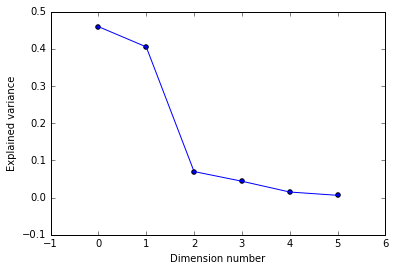

In [4]:
plt.plot(pca.explained_variance_ratio_)
plt.scatter(xrange(6), pca.explained_variance_ratio_)
plt.ylabel("Explained variance")
plt.xlabel("Dimension number")

**3)** What do the dimensions seem to represent? How can you use this information?

Answer: 
- Every dimension seems to represent the importance of a category of item.
- Every component seems to represent a different kind of buyer. 
- Combined together we see 6 different typical customers with their buying habits. Last one for example described mostly by the lack of "detergent paper" and "delicatessen" and the presence of grocery (but also keeping in mind that this last component only reprensents .6% of the variance)
- So we could combine items together in special offers or layout on the floor to maximise spending.

### ICA

In [5]:
# TODO: Fit an ICA model to the data
# Note: Adjust the data to have center at the origin first!
from sklearn.decomposition import FastICA
ica = FastICA()
S_ = ica.fit_transform(data)
A_ = ica.mixing_
print np.dot(S_, A_.T).shape
# Print the independent components
print pd.DataFrame(
    ica.components_, 
    columns = ['PC{}'.format(i) for i in range(1,7)],
    index = ['Fresh', 'Milk', 'Grocery','Frozen', 'Detergents_Paper', 'Delicatessen']
    )

(440, 6)
                           PC1           PC2           PC3           PC4  \
Fresh             1.975718e-07 -1.745236e-06  7.256264e-06  3.002750e-07   
Milk             -3.978524e-06  8.773944e-07  7.504252e-07  6.664713e-07   
Grocery          -3.877177e-07 -2.026075e-07 -5.940163e-07 -5.112360e-07   
Frozen           -1.573007e-07 -9.808037e-06  5.948710e-06  3.351463e-07   
Detergents_Paper -2.739332e-07  2.557211e-06  1.150108e-05 -1.490365e-06   
Delicatessen      8.635962e-07  1.495940e-07 -7.755101e-07 -1.114812e-05   

                           PC5           PC6  
Fresh            -2.757075e-06 -1.867755e-06  
Milk             -2.337444e-06  9.806827e-07  
Grocery           5.047233e-07  1.806954e-05  
Frozen           -3.689024e-06  6.024651e-06  
Detergents_Paper -2.801530e-05 -5.717353e-06  
Delicatessen      5.382032e-07  5.964135e-06  


In [6]:
#  Just to put it on a more visiable scale I'll multiply by 1000000
print pd.DataFrame(
    ica.components_*1000000, 
    columns = ['PC{}'.format(i) for i in range(1,7)],
    index = ['Fresh', 'Milk', 'Grocery','Frozen', 'Detergents_Paper', 'Delicatessen']
    )

                       PC1       PC2        PC3        PC4        PC5  \
Fresh             0.197572 -1.745236   7.256264   0.300275  -2.757075   
Milk             -3.978524  0.877394   0.750425   0.666471  -2.337444   
Grocery          -0.387718 -0.202607  -0.594016  -0.511236   0.504723   
Frozen           -0.157301 -9.808037   5.948710   0.335146  -3.689024   
Detergents_Paper -0.273933  2.557211  11.501083  -1.490365 -28.015298   
Delicatessen      0.863596  0.149594  -0.775510 -11.148120   0.538203   

                        PC6  
Fresh             -1.867755  
Milk               0.980683  
Grocery           18.069545  
Frozen             6.024651  
Detergents_Paper  -5.717353  
Delicatessen       5.964135  


**4)** For each vector in the ICA decomposition, write a sentence or two explaining what sort of object or property it corresponds to. What could these components be used for?

Answer: ICA is trying to find independant signals in the orginal data. Something independant that, when mixed together, produce the data that we have. As suggested by Mitchell in this [post](https://discussions.udacity.com/t/feature-reduction-ica-pca/39131/3) this could be a deli counter in a grocery store or a bar attached to a restaurant. This could be an owner with two types of establishments and orders everything together. So let's look at every components and try to come up with an explanation for them.

Just a note, wholesale is selling in bulk. It could be to either regular households or businesses. I will sometimes provide an explanation for one or the other or both.

**PC1**
- Lack of Detergents and Paper is dominant. This could represent a restaurant that outsources the cleaning to an outside firm. This could also be valid for household that hire a maid. This could also be someone who lives in the city that has to go to a laundry  mat.

**PC2**
- Lack of grocery and a presence of fresh produce could be a catering service. They only use fresh food. This could also be the kind of customers that avoid cans and focus on fresh ingredients. Paleo diet would correspond to that.

**PC3**
- Strong presence of Fresh, Grocery and Frozen. This sounds a lot like the typical family of two adults and two kids.

**PC4**
- Big focus on Milk. Ice cream shop comes to mind.

**PC5**
- Buys pretty much everything except Fresh. Fresh tend to cost more than, say, a box of pasta it could be avoided by low income families. But seeing Delicatessen as the only positive value I would rather think that this is a group of people that are often outside home and prefers products without expiration dates but sometimes treat themselves. This could be a group of career oriented people.

**PC6**
- This could be complementary to PC5 where the people tend to eat outside of home, this component could be the deli or sandwich place that this person goes to. It's mostly influenced by the presence of Delicatessen and a place that sells fresh products (Subway for exemple) would be a bigger consumer of this.

## Clustering

In this section you will choose either K Means clustering or Gaussian Mixed Models clustering, which implements expectation-maximization. Then you will sample elements from the clusters to understand their significance.

### Choose a Cluster Type

**5)** What are the advantages of using K Means clustering or Gaussian Mixture Models?

Answer: 
- The advantage of K Means is 
    - that *it scales well to large number of samples and has been used across a large range of application areas in many different fields*
    - *K-means will always converge, however this may be to a local minimum* [1](http://scikit-learn.org/stable/modules/clustering.html#k-means)
    - Because of its simplicity it's easy to understand
    - Much easier to interpret the results (centroids) than more complicated algorithms
    
- The advantages of GMM
    - Instead of defining a hard limit to divide the space as with K-Means and Voronoi diagrams it allows every point to have a "membership" to every clusters
    - If needed a "no man's land" can be defined. Meaning that your membership can be at least as strong as a certain treshold to declare you of a certain cluster
    - Gaussians are often well behaved: algorithmically friendly, differentiable, mean and variance is well understood.

**6)** Below is some starter code to help you visualize some cluster data. The visualization is based on [this demo](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) from the sklearn documentation.

In [7]:
# Import clustering modules
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

In [8]:
# TODO: First we reduce the data to two dimensions using PCA to capture variation
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data)
print reduced_data[:10]  # print upto 10 elements

[[  -650.02212207   1585.51909007]
 [  4426.80497937   4042.45150884]
 [  4841.9987068    2578.762176  ]
 [  -990.34643689  -6279.80599663]
 [-10657.99873116  -2159.72581518]
 [  2765.96159271   -959.87072713]
 [   715.55089221  -2013.00226567]
 [  4474.58366697   1429.49697204]
 [  6712.09539718  -2205.90915598]
 [  4823.63435407  13480.55920489]]


In [9]:
# TODO: Implement your clustering algorithm here, and fit it to the reduced data for visualization
# The visualizer below assumes your clustering object is named 'clusters'
clusters = GMM(n_components=6)
clusters.fit(reduced_data)
clusters
print clusters

GMM(covariance_type='diag', init_params='wmc', min_covar=0.001,
  n_components=6, n_init=1, n_iter=100, params='wmc', random_state=None,
  thresh=None, tol=0.001, verbose=0)


In [10]:
# Plot the decision boundary by building a mesh grid to populate a graph.
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Obtain labels for each point in mesh. Use last trained model.
Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])

In [11]:
# TODO: Find the centroids for KMeans or the cluster means for GMM 
centroids = clusters.means_
print centroids

[[  2917.75633744  -7172.67502341]
 [  3172.01367966  13259.54628747]
 [-31722.83442405  -6802.26852706]
 [-18416.8385771   45914.98214137]
 [ -5775.25608572  -2804.02019039]
 [  9533.08979559   2875.86777608]]


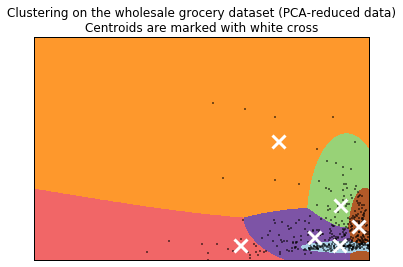

In [12]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

**7)** What are the central objects in each cluster? Describe them as customers.

Answer: 
- The central objects are the means of every gaussian mixtures. Data points are given a class based on which mixture provides the highest probability but it has a "membership" to all other mixtures as well. It's a little bit of this and a little bit of that. The central objects are the highest point of every mixtures.
- Choosing the top two dimensions of the PCA, we see that the points spread along both axis
- If we see the central points, the means of the gaussians, as customers they would be your average customer for that group. If we were to have stereotypes for those groups, the central points would be your champion, the face of every group.

### Conclusions

** 8)** Which of these techniques did you feel gave you the most insight into the data?

Answer: 
- A combination of both is really the answer here especially if we can cover enough variance with 3 dimensions or less. Reducing the number of dimensions enough allow you to visualize your dataset.
- With this visualization you can then judge if the KMean or GMM is struggling to find groups or if you can see the pattern that they detected.
- Choosing just one or the other I would go for GMM or Kmean alone. PCA and ICA are really hard to interpret. Clustering algorithms on the other hand allow you to separate your dataset into smaller groups so you can try to find what makes that group unique.

**9)** How would you use that technique to help the company design new experiments?

Answer: 
- Understanding your customers can give you an advantage on how to increase their spending. As I mentionned above you could have complementary offers that would be attractive to your most important group. Or change the layout of your store to either bring products that sell well together or go in the opposite direction completely and put them far appart so you get more traffic on the floor.

**10)** How would you use that data to help you predict future customer needs?

Answer:  
- You could try to predict the impact of the socio-economical realities on your groups. For example, if you figure out that you have a group of young parents then you know they won't need diapers for the next 5 years. Their needs will evolve. Or if your customers are other businesses and you find out that there is a group that are best represented as Sport Restaurant then you better be ready for the Stanley Cup, the Super Bowl and the World Series with enough chicken wings and pop corn.